In [3]:
import torch, torchvision
x = torch.rand(5, 3)
print(x)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

tensor([[0.2142, 0.7304, 0.4672],
        [0.0873, 0.6380, 0.3340],
        [0.0041, 0.4695, 0.4358],
        [0.2854, 0.8938, 0.1048],
        [0.7832, 0.6955, 0.0373]])
cpu


## Dataset Loading

In [6]:
import os
import pandas as pd
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch

In [21]:

transform = transforms.Compose(
    [transforms.Resize([256, 256]),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.ImageFolder(root='./traffic_Data/DATA/', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root='./traffic_Data/TEST/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Labels

In [22]:

labels_df = pd.read_csv('./labels.csv')
lables = labels_df.iloc[:,0].to_list()
classes = labels_df.iloc[:,1].to_list()
print(classes)

['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Speed limit (30km/h)', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'speed limit (80km/h)', 'Dont Go straight or left', 'Dont Go straight or Right', 'Dont Go straight', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont overtake from Left', 'No Uturn', 'No Car', 'No horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Go straight or right', 'Go straight', 'Go Left', 'Go Left or right', 'Go Right', 'keep Left', 'keep Right', 'Roundabout mandatory', 'watch out for cars', 'Horn', 'Bicycles crossing', 'Uturn', 'Road Divider', 'Traffic signals', 'Danger Ahead', 'Zebra Crossing', 'Bicycles crossing', 'Children crossing', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Unknown1', 'Unknown2', 'Unknown3', 'Go right or straight', 'Go left or straight', 'Unknown4', 'ZigZag Curve', 'Train Crossing', 'Under Construction', 'Unknown5', 'Fences', 'Heavy Vehicle Accidents'

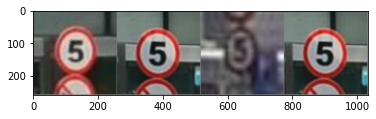

Speed limit (5km/h) Speed limit (5km/h) Speed limit (5km/h) Speed limit (5km/h)


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Convolutional Net

In [29]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [31]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x59536 and 400x120)

### Saving Net

In [33]:
PATH = './model'
torch.save(net.state_dict(), PATH)

## Testing

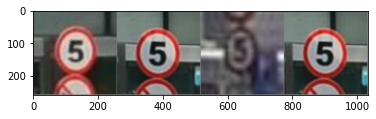

GroundTruth:  Speed limit (5km/h) Speed limit (5km/h) Speed limit (5km/h) Speed limit (5km/h)


In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [34]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

## Accuracy

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
